In [3]:
import numpy as np 
import lmfit as lm 
import pandas as pd 
import os 
import sys 
sys.path.append('C:/Users/Amalya/Research_Local/SpectralFuncs/')
from General_Functions_ACJ import * 
from Raman_Analysis_Functions import *
from scipy.optimize import curve_fit as curve_fit
from scipy.optimize import root_scalar
from scipy.optimize import minimize
from scipy.special import iv, kn, kv, ive, kve
import scipy.integrate as integrate 
from PIL import Image

Sources: 
1. J. Judek, A. P. Gertych, M. Świniarski, A. Łapińska, A. Dużyńska, M. Zdrojek, High accuracy determination of the thermal properties of supported 2D materials. Scientific Reports 5, 12422 (2015).
2.  W. Cai, A. L. Moore, Y. Zhu, X. Li, S. Chen, L. Shi, R. S. Ruoff, Thermal Transport in Suspended and Supported Monolayer Graphene Grown by Chemical Vapor Deposition. Nano Lett. 10, 1645–1651 (2010).
3.  A. Taube, J. Judek, A. Łapińska, M. Zdrojek, Temperature-Dependent Thermal Properties of Supported MoS 2 Monolayers. ACS Appl. Mater. Interfaces 7, 5061–5065 (2015).
4.  X. Zhang, D. Sun, Y. Li, G.-H. Lee, X. Cui, D. Chenet, Y. You, T. F. Heinz, J. C. Hone, Measurement of Lateral and Interfacial Thermal Conductivity of Single- and Bilayer MoS 2 and MoSe 2 Using Refined Optothermal Raman Technique. ACS Appl. Mater. Interfaces 7, 25923–25929 (2015).




Temperature distribution $T(r)$ in a 2D material in the diffusive region in the presence of laser heating, ignoring the substrate: 

\begin{equation}
    \kappa h \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial T}{\partial r} \right) - g (T - T_a) + \frac{Q}{\pi r_0^2} e^{-r^2 / r_0^2} = 0 \tag{1}
\end{equation}


$\kappa$ : thermal conductivity of 2D material \
$h$ : thickness \
$g$ : total interface conductance between sample and substrate of constant temperature $T_a$ \
$Q$ : total absorbed laser power \
$r_0$: beam size

Eqtn. (1) has a physical solution of the form: 

\begin{equation}
    T(r) = \frac{Q}{\kappa h \pi r_0^2} \int_0^\infty F(\kappa, g, r, y) e^{-\frac{y^2}{r_0^2}} y \; \mathrm{dy} \tag{2} 

\end{equation}

where

\begin{equation}
F(\kappa, g, r, y) = 
\left\{
    \begin{array}{lr}
        K_0(\sqrt{g/(\kappa \cdot h)} \cdot r ) \cdot I_0(\sqrt{g/(\kappa \cdot h)} \cdot y), & \text{if } y \leq r\\
        I_0(\sqrt{g/(\kappa \cdot h)} \cdot r ) \cdot K_0(\sqrt{g/(\kappa \cdot h)} \cdot y), & \text{if } y > r
    \end{array}
\right\}
\tag{3}
\end{equation}

$I_0(x)$ : zero-ordered modified Bessel function of the first kind (scipy.special.iv) \
$K_0(x)$ : zero-ordered modified Bessel function of the second kind (scipy.special.kv)

The laser beam is simultaneously heating the sample and probing the local temperature increase & is spatially distributed. THe temperature increase distribution should be averaged to obtain the compatibility with the experimental temperature increase value obtained from Raman measurements $(T(r) \rarr T_m)$

\begin{equation}
    T_m = \frac{\int_0^\infty T(r) r e^{-r^2 / r_0^2} \mathrm{dr}}{\int_0^\infty r e^{-r^2 / r_0^2} \mathrm{dr}} \tag{4}
\end{equation}

\begin{equation}
    T_m(\kappa, g, r_0, Q) = \frac{2Q}{\kappa h \pi r_0^4 }\int_0^\infty \int_0^\infty T(r) e^{-\frac{r^2 + y^2}{r_0^2}} y\mathrm{dy} r\mathrm{dr} \tag{5}
\end{equation}

Plotting the Temperature Profile (eqtn. 1)

In [4]:
def integrand_T(y, r, k, g, r0, h): 
    """
    Integrand in eqtn 1
    """
    x = np.sqrt(g/(k*h))
    I0_r = iv(0,x*r)
    I0_y = iv(0, x*y)
    K0_r = kv(0,x*r)
    K0_y = kv(0, x*y)
    if y <= r: 
        F = K0_r * I0_y
    else: 
        F = K0_y * I0_r
    
    return F * np.exp(-y**2 /r0**2) * y


# Graphene thermal properties found from Ref. [2]
k = 370 #W/mK
h = 0.335e-9 #m
r0 = 0.17e-6 #m #100X objective 
# r0 = 0.28e-6 #m #50x objective
g = 28e6 #W/m2K
Q = 0.5e-3 #W
const = Q / (k * h * np.pi * r0**2)

T = []
# Find T(r) from 0 to 100um in steps of 0.01um
rr = np.arange(0, 25e-6, 0.001e-6)

for r in rr: 
    # We are integrating over all space (y) for each value of r. Limits of integration found to not break the code
    sol = const * integrate.quad(integrand_T, 1e-8, 4e-6, args=(r,k, g, r0, h))[0]
    T.append(sol)
T = np.array(T)

Text(0, 0.5, 'Temperature (K)')

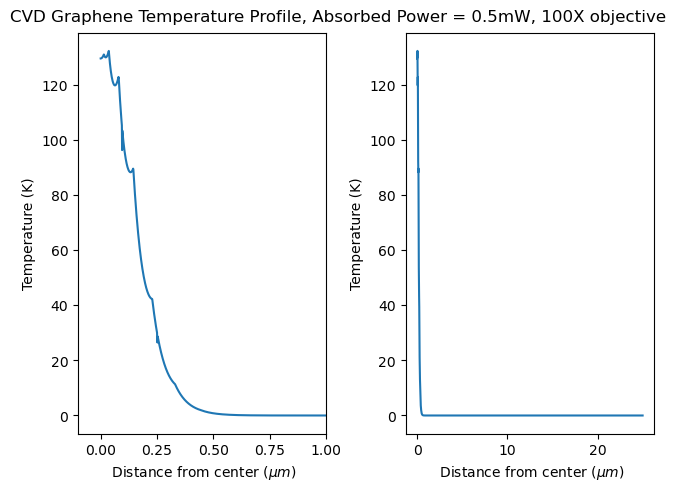

In [5]:
f, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True)
f.suptitle('CVD Graphene Temperature Profile, Absorbed Power = 0.5mW, 100X objective')
ax2.plot(rr*1e6, T)
ax2.set_xlabel(rf' Distance from center ($\mu m$)')
ax1.plot(rr*1e6, T)
ax1.set_xlabel(rf' Distance from center ($\mu m$)')
ax1.set_xlim(-0.1, 1)
ax1.set_ylabel('Temperature (K)')
ax2.set_ylabel('Temperature (K)')


Solving for $T_m$, the actual temperature measured \
Solve 2 ways. For eqtn 4, the bottom integral can be solved analytically
$$ \int_0^\infty r e^{-r^2/r_0^2} \mathrm{dr} = r_0^2 / 2$$
Thus solve this eqtn: 
\begin{equation}
    T_m = \frac{2}{r_0^2} \int_0^\infty T(r) r e^{-r^2/r_0^2} \mathrm{dr} \tag{6}
\end{equation}

Using Ref. [2] experimental parameters again, recreating Fig. 2


Text(0.5, 1.0, 'Ref 2, Figure 2')

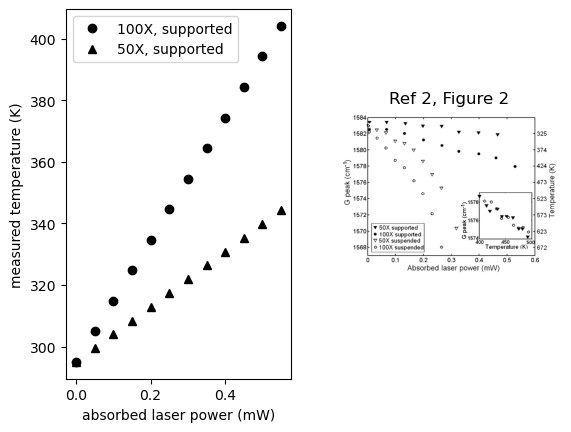

In [6]:
def integrand_Tm(r, Q, k, h, r0, g):
    """ Integrand of Equation 6 """
    const = Q / (k * h * np.pi * r0**2)
    T_r = const * integrate.quad(integrand_T, 0, 10e-6, args=(r, k, g, r0, h))[0]
    return T_r * r * np.exp(-r**2 / (r0**2))

# Solving Tm for absorbed laser power 0.05 to 0.6 mW as in Ref. [2] Fig. 2
Ta = 295 # stage temperature kept at room temperature
hundredX = []
fiftyX  = []
Qarr = np.arange(0, 0.6, 0.05)
for qq in Qarr*1e-3: 
    r0 = 0.17e-6 # spot size 100X objective
    sol = integrate.quad(integrand_Tm, 0, 10e-6, args=(qq, k, h, r0, g))[0] / (r0**2 / 2)
    hundredX.append(Ta + sol)
    r0 = 0.28e-6 # spot size 50X objective
    sol = integrate.quad(integrand_Tm, 0, 10e-6, args=(qq, k, h, r0, g))[0] / (r0**2 / 2)
    fiftyX.append(Ta + sol)

f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(Qarr, hundredX, 'ko', label='100X, supported')
ax1.plot(Qarr, fiftyX, 'k^', label='50X, supported')

ax1.set_ylabel('measured temperature (K)')
ax1.set_xlabel('absorbed laser power (mW)')
ax1.legend()

im = Image.open('C:/Users/Amalya/OneDrive - Stanford/Pictures/Screenshots/Screenshot 2024-01-24 113007.png')
ax2.imshow(im)
ax2.axis('off')
ax2.set_title('Ref 2, Figure 2')

Solve Eqtn. 4 using the double integral (This doesn't work quite yet)

In [7]:
def dblintegrand_Tm(y,r, k, g, r0, h): 
    x = np.sqrt(g/(k*h))
    I0_r = ive(0,x*r)
    I0_y = ive(0, x*y)
    K0_r = kve(0,x*r)
    K0_y = kve(0, x*y)
    if y <= r: 
        F = K0_r * I0_y
    else: 
        F = K0_y * I0_r
    
    return F * np.exp(-(y**2 + r**2) /r0**2) * y * r
k = 370 #W/mK
h = 0.335e-9 #m
g = 28e6 

hundredX = []
fiftyX = []
# I think my bounds are slightly wrong here, but not quite sure how to represent y as a function of r
for qq in Qarr*1e-3: 
    r0 = 0.17e-6 # spot size 100X objective
    const = (2 * qq)  / (k * h * np.pi * r0**4)
    sol = const * integrate.dblquad(dblintegrand_Tm, 0, 10e-6, 0, 10e-6, args=(k, g, r0, h))[0]
    hundredX.append(Ta + sol)

    r0 = 0.28e-6 # spot size 50X objective
    const = (2 * qq)  / (k * h * np.pi * r0**4)
    sol = const * integrate.dblquad(dblintegrand_Tm, 0, 10e-6, 0, 10e-6, args=(k, g, r0, h))[0]
    fiftyX.append(Ta + sol)
hundredX = np.array(hundredX)
fiftyX = np.array(fiftyX)


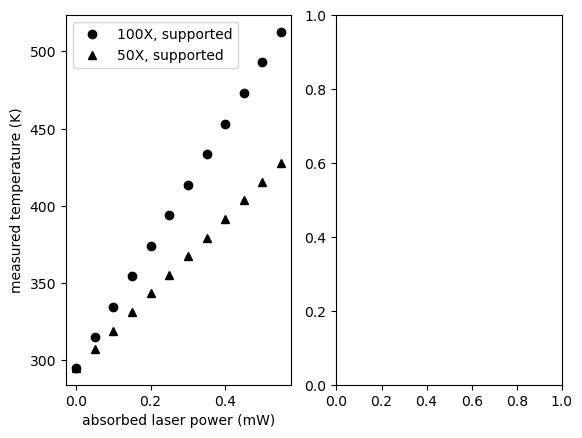

In [8]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(Qarr, hundredX, 'ko', label='100X, supported')
ax1.plot(Qarr, fiftyX, 'k^', label='50X, supported')

ax1.set_ylabel('measured temperature (K)')
ax1.set_xlabel('absorbed laser power (mW)')
ax1.legend()

Recreating Ref 3, Supplemental Figure S1, S2

In [9]:
Q = 1e-3
Q = Q * 0.07
# r0 = 0.72e-6 #50X 
r0 = 0.4e-6 #100x 
k = 62.2 # W/mK
g = 1.94e6 #MW / m2K
Ta = 300 # stage temperature kept at room temperature
h = 0.7e-9 

T = []
# Find T(r) from 0 to 100um in steps of 0.01um
rr = np.arange(0, 25e-6, 0.001e-6)

for r in rr: 
    # We are integrating over all space (y) for each value of r. Limits of integration found to not break the code
    const = Q / (k * h * np.pi * r0**2)
    sol = const * integrate.quad(integrand_T, 1e-8, 4e-6, args=(r,k, g, r0, h))[0]
    T.append(sol)
T = np.array(T)

In [10]:
x = np.arange(-1.5, 1.6, 0.01)*1e-6
y = np.arange(-1.5, 1.6, 0.01)*1e-6
X, Y = np.meshgrid(x,y)

r = np.sqrt(X**2 + Y**2)
# T_100  = np.zeros_like(r)
# T_50  = np.zeros_like(r)

T_100  = np.zeros_like(r)
T_50  = np.zeros_like(r)
Ta = 295
for i in np.arange(len(x)):
    for j in np.arange(len(y)): 
        rij = r[i,j] 
        r0 = 0.4e-6 #100x 
        const = Q / (k * h * np.pi * r0**2)
        T_r = const * integrate.quad(integrand_T, 1e-8, 4e-6, args=(rij,k, g, r0, h))[0]
        T_100[i,j] = Ta + T_r

        r0 = 0.72e-6 #50X 
        const = Q / (k * h * np.pi * r0**2)
        T_r = const * integrate.quad(integrand_T, 1e-8, 4e-6, args=(rij,k, g, r0, h))[0]
        T_50[i,j] = Ta + T_r


Text(0.5, 1.0, 'Ref 3, Figure S1')

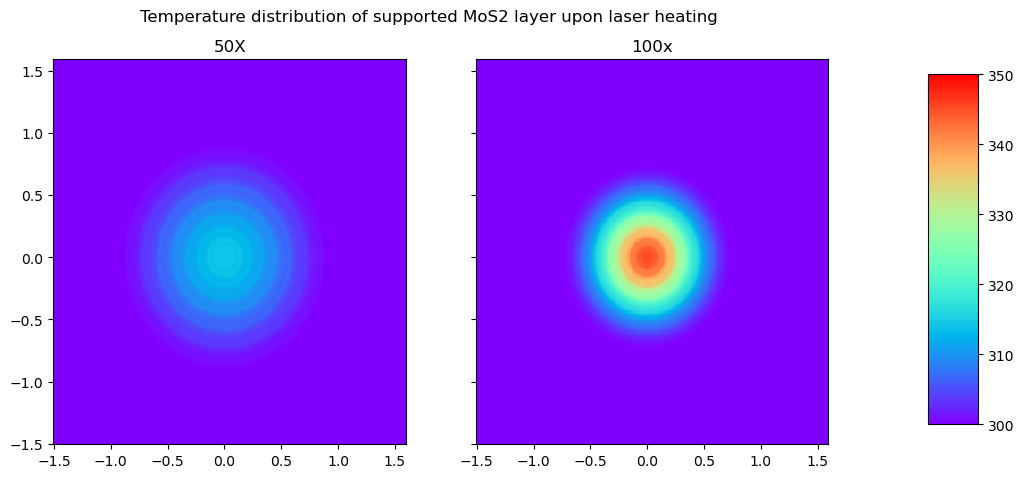

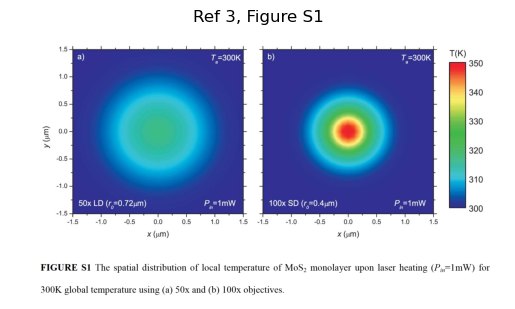

In [11]:
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
im = ax1.pcolormesh(X*1e6,Y*1e6,T_50, cmap=plt.cm.rainbow, vmin=300, vmax=350)
cbar_ax = f.add_axes([1, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)
ax2.pcolormesh(X*1e6,Y*1e6,T_100, cmap=plt.cm.rainbow, vmin=300, vmax=350)
ax1.set_title('50X')
ax2.set_title('100x')
f.suptitle('Temperature distribution of supported MoS2 layer upon laser heating')

im = Image.open("C:/Users/Amalya/OneDrive - Stanford/Pictures/Screenshots/Screenshot 2024-01-25 105556.png")
plt.figure()
plt.imshow(im)
plt.axis('off')
plt.title('Ref 3, Figure S1')

Text(0.5, 1.0, 'Ref 3, Figure S2')

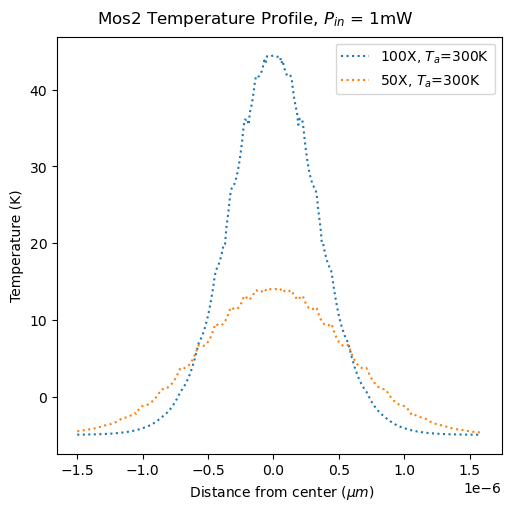

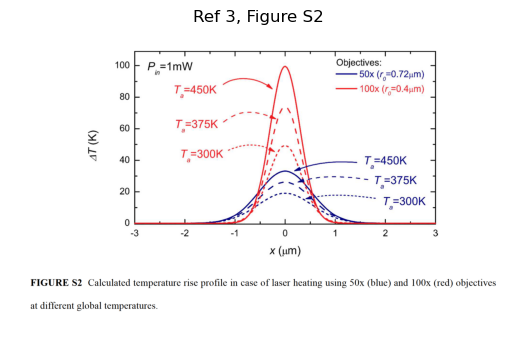

In [12]:
f, (ax1) = plt.subplots(1,1, constrained_layout=True, figsize=(5,5))
f.suptitle('Mos2 Temperature Profile, $P_{in}$ = 1mW')
ax1.plot(x, T_100[:,int(len(T_100)/2)] - 300, linestyle=':', label=rf'100X, $T_a$=300K')
ax1.plot(x, T_50[:,int(len(T_100)/2)] - 300,linestyle=':', label=rf'50X, $T_a$=300K')

# ax1.plot(x, T_100_400[:,int(len(T_100_400)/2)] - 450, label=rf'100X, $T_a$=450K')
# ax1.plot(x, T_50_400[:,int(len(T_100_400)/2)] - 450, label=rf'50X, $T_a$=450K')
ax1.set_xlabel(rf' Distance from center ($\mu m$)')
# ax1.set_xlim(-0.1, 1)
ax1.set_ylabel('Temperature (K)')
ax1.legend()
# ax2.set_ylabel('Temperature (K)')

im = Image.open("C:/Users/Amalya/OneDrive - Stanford/Pictures/Screenshots/Screenshot 2024-01-25 105924.png")
plt.figure()
plt.imshow(im)
plt.axis('off')
plt.title('Ref 3, Figure S2')

Replicating Ref. 4 Fig. 3a; using first method for solving $T_m$ 

In [13]:
k = 55 #W/mK
g = 0.44e6 #MW / m2K 
r0 = 0.466e-6 #m 
r0 = 0.62e-6 #m 

Q = 1e-3 # W
h = 0.7e-9

Ta = 295 # stage temperature kept at room temperature
hundredX = []
fiftyX  = []
hundredX_pk = []
fiftyX_pk = []
chi_K = 0.0167 #cm-1/K
chi_W = 0.0204 #cm-1/uW
Qarr = np.arange(0, 60, 5)
for qq in Qarr*1e-6: 
    r0 = 0.466e-6 #m 
    sol = integrate.quad(integrand_Tm, 0, 10e-6, args=(qq, k, h, r0, g))[0] / (r0**2 / 2)
    peak_position = 408 - chi_K * sol
    hundredX.append(Ta + sol)
    hundredX_pk.append(peak_position)

    r0 = 0.62e-6 #m 
    sol = integrate.quad(integrand_Tm, 0, 10e-6, args=(qq, k, h, r0, g))[0] / (r0**2 / 2)
    peak_position = 408 - chi_K * sol
    fiftyX.append(Ta + sol)
    fiftyX_pk.append(peak_position)

Text(0.5, 1.0, 'Ref 4, Figure 3a')

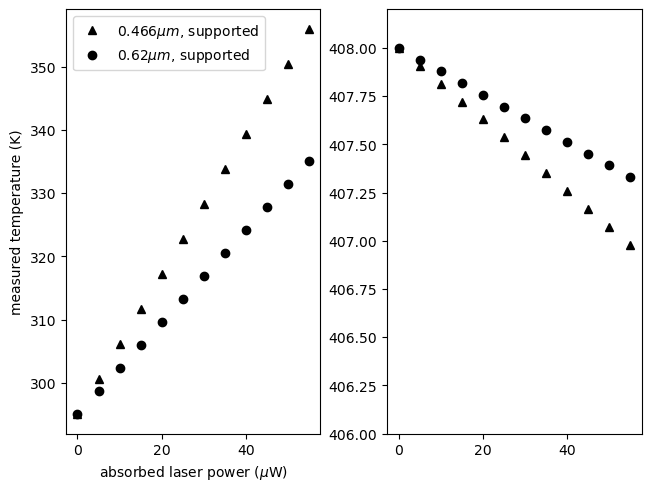

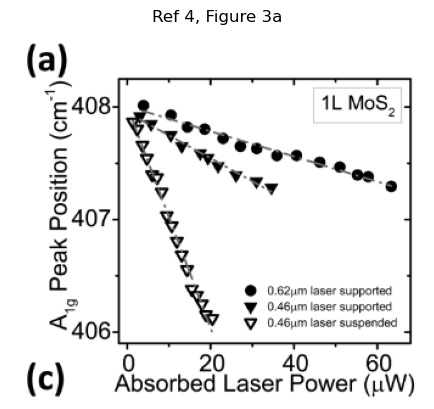

In [14]:
f, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True)
ax1.plot(Qarr, hundredX, 'k^', label='0.466$\mu m$, supported')
ax1.plot(Qarr, fiftyX, 'ko', label='0.62$\mu m$, supported')

ax2.plot(Qarr, hundredX_pk, 'k^', label='0.466$\mu m$, supported')
ax2.plot(Qarr, fiftyX_pk, 'ko', label='0.62$\mu m$, supported')
ax2.set_ylim(406, 408.2)
ax1.set_ylabel('measured temperature (K)')
ax1.set_xlabel(rf'absorbed laser power ($\mu$W)')
ax1.legend()

im = Image.open("C:/Users/Amalya/OneDrive - Stanford/Pictures/Screenshots/Screenshot 2024-01-25 110049.png")
plt.figure()
plt.imshow(im)
plt.axis('off')
plt.title('Ref 4, Figure 3a')

Okay so I think the code works. Now for fitting

What I need\
$\chi_T$ : Temperature coefficient $[cm^{-1}/K]$ From power-dependent data + temperature calibration \
$\chi_W$ : Power shift rate $[cm^{-1}/W]$ From power dependent data \
$\chi_W$ and $\chi_T$ need to get experimental $T_m$ \
$\alpha$ : absorption coefficient to characterize how much light actually absorbed. From absorption data \
$R_m = T_m / P$ : Thermal resistance of each sample  $[K/W]$

The ratio of $R_m$ for the two different spot sizes is a function of the ratio $g / \kappa_s$

\begin{equation}
\frac{R_{m, r_0 = r_1}}{R_{m, r_0 = r_2}} = \frac{T_{m, r_0 = r_1}}{T_{m, r_0 = r_2}} = \frac{r_2^4}{r_1^4} \frac{\int_0^\infty \int_0^\infty F(\kappa, g, r, y) e^{-\frac{y^2}{r_1^2}} y r \; \mathrm{dydr}}{\int_0^\infty \int_0^\infty F(\kappa, g, r, y) e^{-\frac{y^2}{r_2^2}} y r \; \mathrm{dydr}}
\tag{7}
\end{equation}

In [20]:
class solve_ratio:
    """
    Connect experimental data to the theory to solve for g/k and extract thermal properties.
    """ 
    def __init__(self):
        self.r1 = 0
        self.r2 = 0 
        self.h = 0 
        self.Rm1 = 0 
        self.Rm2 = 0


    def Tr(self, y, r, ratio, r0):   
        """
        T(r) function
        """
        x = np.sqrt((ratio)*1/self.h)
        I0_r = iv(0,x*r)
        I0_y = iv(0, x*y)
        K0_r = kv(0,x*r)
        K0_y = kv(0, x*y)
        if y <= r: 
            F = K0_r * I0_y
        else: 
            F = K0_y * I0_r
        
        return F * np.exp(-y**2 /r0**2) * y
    
    def Tm(self, r, ratio, r0): 
        """
        T(m) function
        """
        const = 1 / (r0**2)
        T_r = const * integrate.quad(self.Tr, 0, 10e-6, args=(r, ratio, r0))[0]
        return T_r * r * np.exp(-r**2 / (r0**2))

    def Tm_solve(self, r, ratio, r0): 
        const = 1
        T_r = const * integrate.quad(self.Tr, 0, 10e-6, args=(r, ratio, r0))[0]
        return T_r * r * np.exp(-r**2 / (r0**2))
    
    def get_ratio(self, ratio): 
        """
        Deduce what ratio g/k gives Tm1/Tm2 that equals the experimental Rm1/Rm2
        """
        Tm_1 = integrate.quad(self.Tm, 0, 10e-6, args=(ratio, self.r1))[0] * (1/self.r1**2)
        Tm_2 = integrate.quad(self.Tm, 0, 10e-6, args=(ratio, self.r2))[0] * (1/self.r2**2)
        self.Tm_ratio = (Tm_1 / Tm_2) 
        if self.Rm2 == 0: 
            raise ZeroDivisionError('Experimental Data not given!, input Rm1 and Rm2 and run again')
        else: 
            self.experimental_ratio = self.Rm1/self.Rm2
        return self.Tm_ratio - self.experimental_ratio

    def find_root(self):
        """
        Minimize the get ratio function to find a simulated Tm1/Tm2 that = the experimental Rm1/Rm2
        """
        result = minimize(self.get_ratio, x0=100)
        self.result = result
        self.minimum = result['x']

    def thermal_properties(self): 
        """
        Conduct minimization and extract the thermal properties
        """
        try: 
            found_ratio = self.minimum
        except AttributeError: 
            self.find_root()
            found_ratio = self.minimum
        self.k1 = integrate.quad(self.Tm_solve, 0, 10e-6, args=(found_ratio, self.r1))[0] * (1/self.r1**4) * 2 * (1/(self.h * np.pi * self.Rm1))
        self.g1 = found_ratio[0] * self.k1

        self.k2 = integrate.quad(self.Tm_solve, 0, 10e-6, args=(found_ratio, self.r2))[0] * (1/self.r2**4) * 2 * (1/(self.h * np.pi * self.Rm2))
        self.g2 = found_ratio[0] * self.k2
        print(f'k1:{self.k1} W/mK, g:{round(self.g1 / 1e6, 2)} MW/m2K')
        print(f'k2:{self.k2} W/mK, g:{round(self.g2 / 1e6, 2)} MW/m2K')
   

In [16]:
test = solve_ratio()

# Inputing experimental data from ref [4] to test model
#MoS2 
test.r1 = 0.62e-6 #m
test.r2 = 0.466e-6 #m
test.h = 0.7e-9 #m 
test.Rm1 = 0.671e6 #K/W
test.Rm2 = 1.222e6 #K/W
k = 55 #W/mK
g = 0.44e6

#graphene
# test.r1 = 0.17e-6
# test.r2 = 0.28e-6
# test.h = 0.335e-9
# test.Rm1 = 2.37e5
# test.rm2 = 1.05e5
# k = 370 #W/mK
# g = 28e6 #W/m2K
# # ratio = g/k

Using the first spot size to obtain thermal properties: obtain $\kappa \approx 63.03$ $W/mK$, $g \approx 0.47$ $MW/m^2K$ \
Using the second spot size to obtain thermal properties: obtain $\kappa \approx 52.4$ $W/mK$, $g \approx 0.39$ $MW/m^2K$

Averaging these two get $\kappa \approx 57.715$   $W/mK$, g $\approx 0.43$   $MW/m^2K $ \
The paper the parameters input comes from reports  $\kappa \approx 55$   $W/mK$, g $\approx 0.44$   $MW/m^2K $ \
Nice!

In [17]:
test.find_root()
test.thermal_properties()

k1:63.0343270579622 W/mK, g:0.47 MW/m2K
k2:52.40303404359586 W/mK, g:0.39 MW/m2K
